# <div style="color:#fff;display:fill;border-radius:10px;background-color:#004F98;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">Brain Tumor detection Using Deep Learning | Transfer Learning ResNet</div>

## <span style='color:#2E8BC0'> 0| Import Libraries</span>

In [1]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers

## <span style='color:#2E8BC0'> 1| Read Dataset </span>

In [10]:
glioma_train_data = os.listdir(r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training\glioma")
glioma_test_data =os.listdir ( r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Testing\glioma")

glioma_images = {'Num Of Train Images': len(glioma_train_data),
                'Num Of Test Images': len(glioma_test_data)
                }

In [11]:
print(glioma_images)

{'Num Of Train Images': 1321, 'Num Of Test Images': 300}


In [12]:
meningioma_train_data = os.listdir(r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training\meningioma")
meningioma_test_data =os.listdir ( r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Testing\meningioma")

meningioma_images = {'Num Of Train Images': len(meningioma_train_data),
                'Num Of Test Images': len(meningioma_test_data)
                }

In [13]:
print(meningioma_images)

{'Num Of Train Images': 1339, 'Num Of Test Images': 306}


In [14]:
notumor_train_data = os.listdir(r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training\notumor")
notumor_test_data =os.listdir ( r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Testing\notumor")

notumor_images = {'Num Of Train Images': len(notumor_train_data),
                'Num Of Test Images': len(notumor_test_data)
                }

In [15]:
print(notumor_images)

{'Num Of Train Images': 1595, 'Num Of Test Images': 405}


In [16]:
pituitary_train_data = os.listdir(r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training\pituitary")
pituitary_test_data =os.listdir ( r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Testing\pituitary")

pituitary_images = {'Num Of Train Images': len(pituitary_train_data),
                'Num Of Test Images': len(pituitary_test_data)
                }

In [17]:
print(pituitary_images)

{'Num Of Train Images': 1457, 'Num Of Test Images': 300}


## <span style='color:#2E8BC0'> 2| Visualization Images </span>

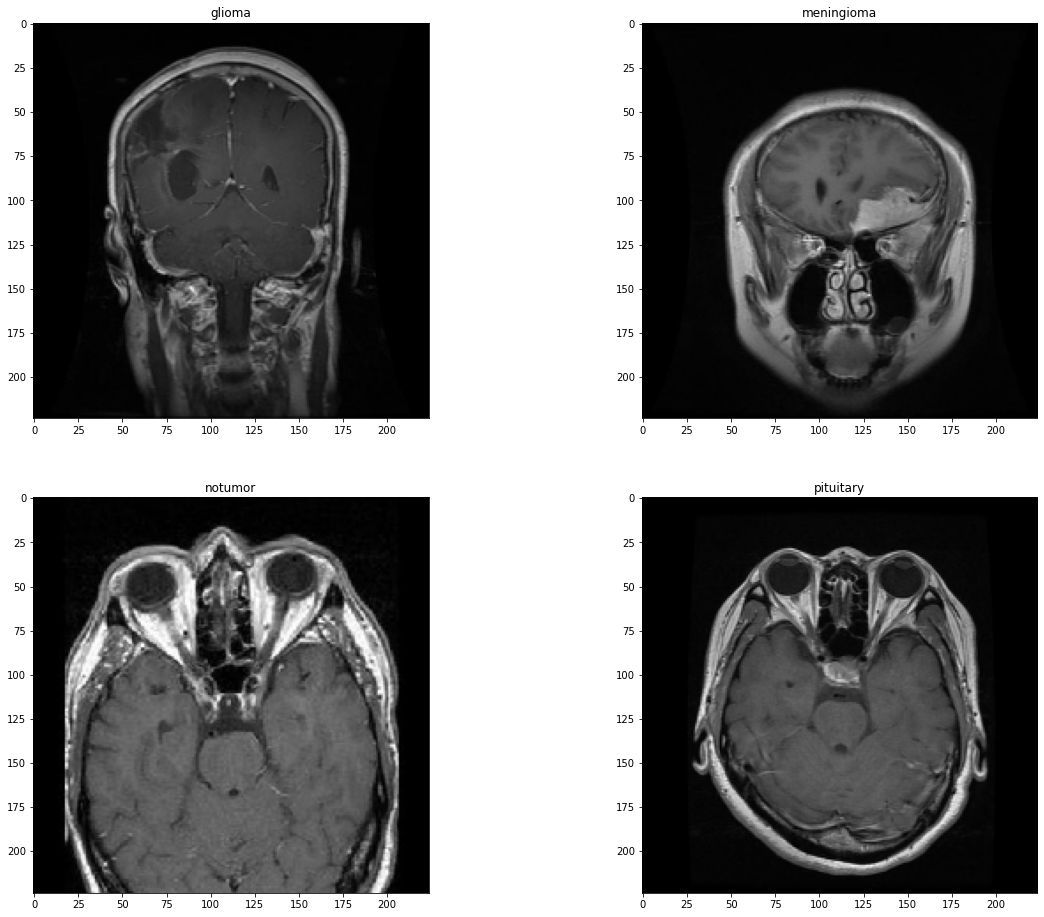

In [22]:
data_dir = (r'C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-gl_0010.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])

## Crop Images

In [26]:


def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
     

In [28]:

img = cv2.imread(r'C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training\meningioma\Tr-meTr_0000.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

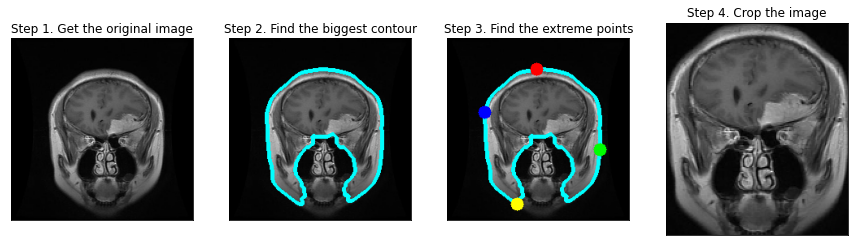

In [29]:

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [33]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join(r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Training",label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join(r"C:\Users\lenovo\Desktop\Projects\Neural network(NN)\Brain Tumor detection\dataset\Testing",label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 481.29it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


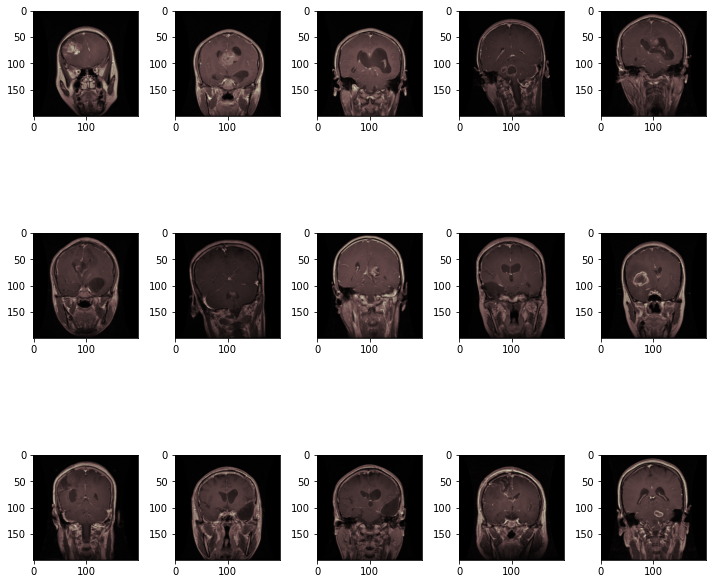

In [34]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

## <span style='color:#2E8BC0'> 3| Splitting Data </span>

In [35]:

x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tensorflow.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


## <span style='color:#2E8BC0'> 4| Data Augementation </span>

In [36]:

# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


os.mkdir('preview_2')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview_2', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
     

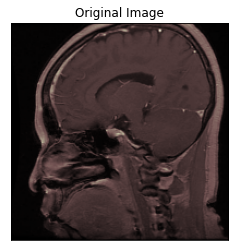

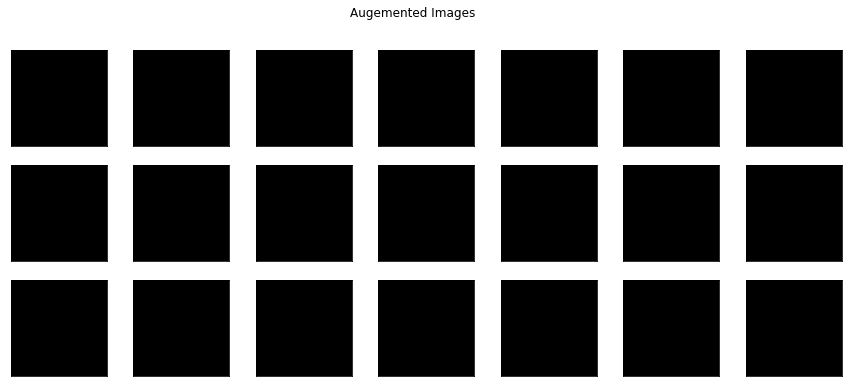

In [40]:

plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_2/'):
    img = cv2.imread('preview_2/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [41]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## <span style='color:#2E8BC0'> 5| Building Model </span>

In [42]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [43]:
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

In [44]:
#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 50, 50, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 50, 50, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 25, 25, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [46]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [47]:
train_len = len(x_train)
val_len = len(x_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
4569
-----------Validation Data length-----------------
1143


In [48]:

history = model.fit(datagen.flow(x_train, y_train, batch_size=64),validation_data = (x_val,y_val),epochs = 50,callbacks = callbacks)
     

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8851
Epoch 1: val_loss improved from inf to 5.81995, saving model to .mdl_wts.hdf5
72/72 [==============================] - 522s 7s/step - loss: 0.3113 - accuracy: 0.8851 - val_loss: 5.8200 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9729
Epoch 2: val_loss improved from 5.81995 to 4.02143, saving model to .mdl_wts.hdf5
72/72 [==============================] - 477s 7s/step - loss: 0.0811 - accuracy: 0.9729 - val_loss: 4.0214 - val_accuracy: 0.2695 - lr: 1.0000e-04
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9799
Epoch 3: val_loss did not improve from 4.02143
72/72 [==============================] - 487s 7s/step - loss: 0.0577 - accuracy: 0.9799 - val_loss: 4.4557 - val_accuracy: 0.2546 - lr: 1.0000e-04
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.

72/72 [==============================] - 501s 7s/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.1181 - val_accuracy: 0.9825 - lr: 2.7000e-06
Epoch 27/50
72/72 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9993
Epoch 27: val_loss improved from 0.11806 to 0.11729, saving model to .mdl_wts.hdf5
72/72 [==============================] - 498s 7s/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.1173 - val_accuracy: 0.9825 - lr: 2.7000e-06
Epoch 28/50
72/72 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9991
Epoch 28: val_loss did not improve from 0.11729
72/72 [==============================] - 512s 7s/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.1176 - val_accuracy: 0.9825 - lr: 2.7000e-06
Epoch 29/50
72/72 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991
Epoch 29: val_loss improved from 0.11729 to 0.11631, saving model to .mdl_wts.hdf5
72/72 [==============================] - 505s 7s/step - loss

## <span style='color:#2E8BC0'> 6| Accuracy Curve </span>

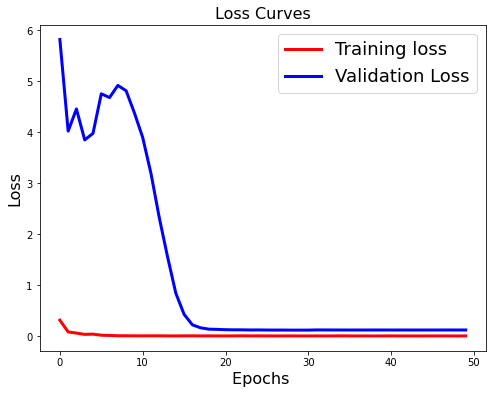

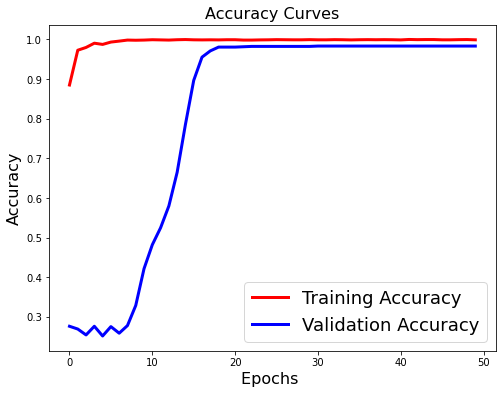

In [49]:
# ==> Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

# ==> Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Validation on Test set

In [50]:

loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 37s 902ms/step - loss: 0.0901 - accuracy: 0.9847


## <span style='color:#2E8BC0'> 7| Save and Loading Model </span>

In [51]:
from tensorflow.keras.models import load_model
model = load_model('.mdl_wts.hdf5')
model.save('C:/Users/lenovo/Desktop/Projects/Neural network(NN)/Brain Tumor detection/modelres50.h5')

model = load_model('C:/Users/lenovo/Desktop/Projects/Neural network(NN)/Brain Tumor detection/modelres50.h5')
     

In [52]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

41/41 [==============================] - 37s 890ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.96      0.98       306
    no_tumor       0.99      0.99      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



164/164 [==============================] - 46s 279ms/step


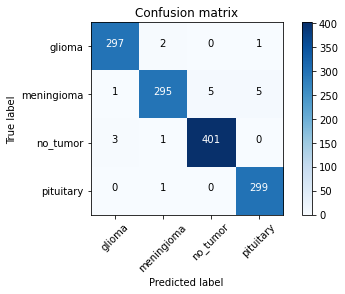

In [53]:

import itertools
pred_Y = model.predict(x_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 
     

82/82 [==============================] - 42s 507ms/step


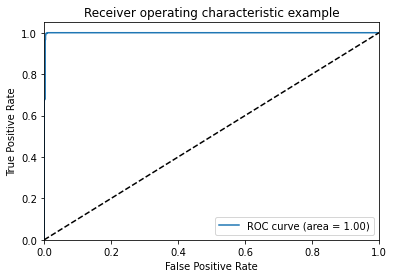

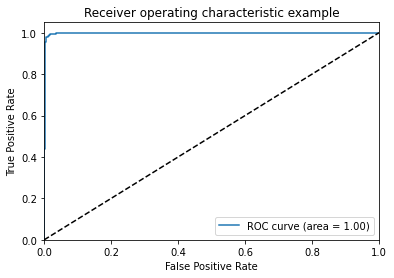

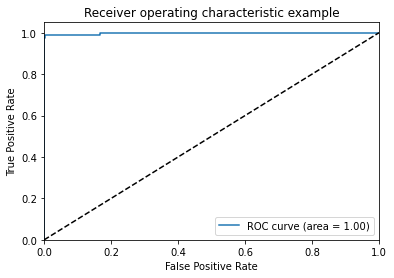

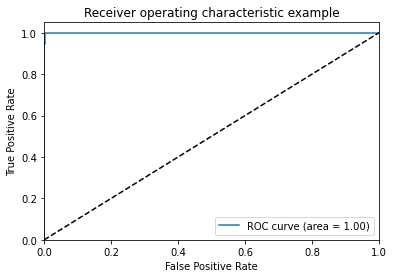

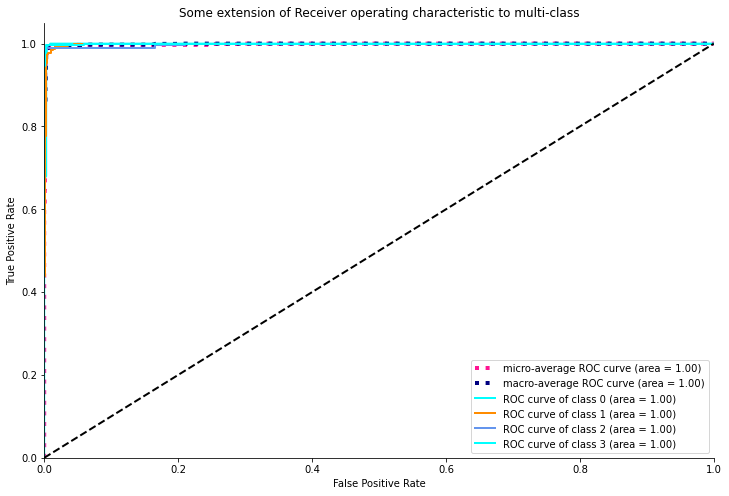

In [54]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = np.array(y_test)

n_classes = 4

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

## <span style='color:#2E8BC0'> 8| Plotting sample predictions </span>

41/41 [==============================] - 37s 908ms/step


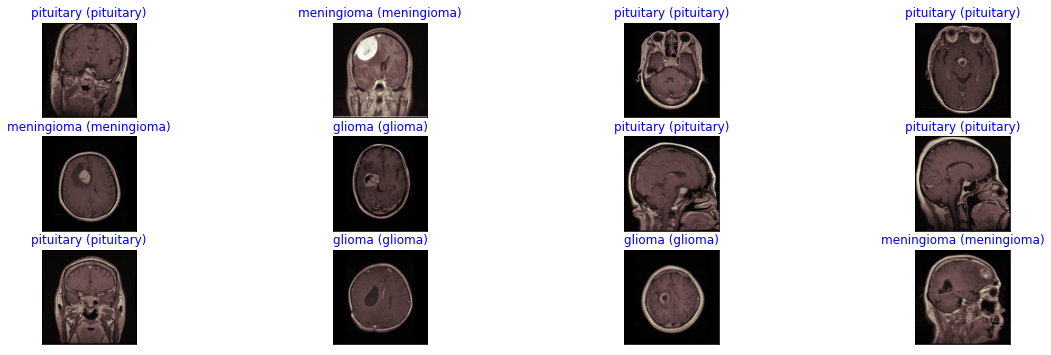

In [55]:

y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))